In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
pd.set_option('use_inf_as_na', True)
import warnings
warnings.filterwarnings('ignore')

In [244]:
crash_data=pd.read_csv('/content/crash_data.csv')

In [245]:
crash_data.head()

,Unnamed: 0,RET,date,TICKER,vwretx,BIDLO,ASKHI,PRC,VOL
0,27882462,0.041833,20100104,BAC,0.017045,15.12,15.750,15.69,180845100.0
1,27882463,0.032505,20100105,BAC,0.003362,15.70,16.210,16.20,209521200.0
2,27882464,0.011728,20100106,BAC,0.001769,16.03,16.540,16.39,205257900.0
3,27882465,0.032947,20100107,BAC,0.002821,16.51,17.185,16.93,320868400.0
4,27882466,-0.008860,20100108,BAC,0.004161,16.63,17.100,16.78,220104600.0


In [246]:
crash_data.date=pd.to_datetime(crash_data.date, format='%Y%m%d')
crash_data=crash_data.set_index('date')

In [247]:
crash_dataw=crash_data.groupby('TICKER').resample('W').\
agg({'RET':'mean', 'vwretx':'mean', 'VOL':'mean',
     'BIDLO':'mean', 'ASKHI':'mean', 'PRC':'mean'})

In [248]:
crash_dataw=crash_dataw.reset_index()
crash_dataw.dropna(inplace=True)
stocks=crash_dataw.TICKER.unique()

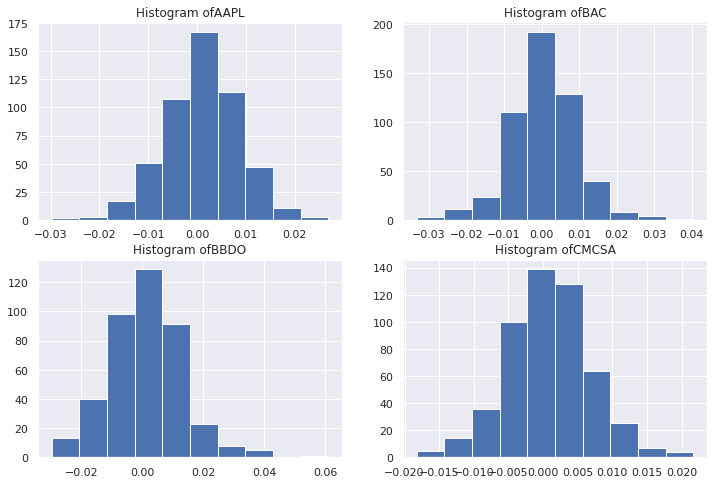

In [249]:
plt.figure(figsize=(12,8))
k=1

for i in stocks[:4]:
  plt.subplot(2,2,k)
  plt.hist(crash_dataw[crash_dataw.TICKER==i]['RET'])
  plt.title('Histogram of'+i)
  k+=1
plt.show()

In [250]:
import statsmodels.api as sm
residuals=[]

for i in stocks:
  Y=crash_dataw.loc[crash_dataw['TICKER']==i]['RET'].values
  X=crash_dataw.loc[crash_dataw['TICKER']==i]['vwretx'].values
  X=sm.add_constant(X)
  ols=sm.OLS(Y[2:-2], X[2:-2]+X[1:-3]+X[0:-4]+\
             X[3:-1]+X[4:]).fit()
  residuals.append(ols.resid)


In [251]:
residuals=list(map(lambda x: np.log(1+x), residuals))


In [252]:
crash_data_sliced=pd.DataFrame([])
for i in stocks:
  crash_data_sliced=crash_data_sliced.\
  append(crash_dataw.loc[crash_dataw.TICKER==i]
         [2:-2])
crash_data_sliced.head()

,TICKER,date,RET,vwretx,VOL,BIDLO,ASKHI,PRC
2,AAPL,2010-01-24,-0.009510,-0.009479,25930885.00,205.277505,212.888450,208.146752
3,AAPL,2010-01-31,-0.005426,-0.003738,52020594.00,198.250202,207.338002,201.650398
4,AAPL,2010-02-07,0.003722,-0.001463,26953208.40,192.304004,197.378002,195.466002
5,AAPL,2010-02-14,0.005031,0.002970,19731018.60,194.513998,198.674002,196.895200
6,AAPL,2010-02-21,0.001640,0.007700,16618997.25,201.102500,203.772500,202.636995


In [253]:
from sklearn.covariance import EllipticEnvelope
envelope=EllipticEnvelope(contamination=0.02, support_fraction=1)
ee_predictions={}

for i, j in zip(range(len(stocks)), stocks):
  envelope.fit(np.array(residuals[i]).reshape(-1,1))
  ee_predictions[j]=envelope.predict(np.array(residuals[i])
  .reshape(-1,1))

In [254]:
transform=[]
for i in stocks:
  for j in range(len(ee_predictions[i])):
    transform.append(np.where(ee_predictions[i][j]==1,0,-1))
    

In [255]:
crash_data_sliced=crash_data_sliced.reset_index()
crash_data_sliced['residuals']=np.concatenate(residuals)
crash_data_sliced['neg_outliers']=np.where((np.array(transform))\
                                           ==-1,1,0)
crash_data_sliced.loc[(crash_data_sliced.neg_outliers==1)&
                      (crash_data_sliced.residuals>0),
                      'neg_outliers']=0

In [256]:

crash_data_sliced['neg_outliers'].value_counts()

0    13155
1      131
Name: neg_outliers, dtype: int64

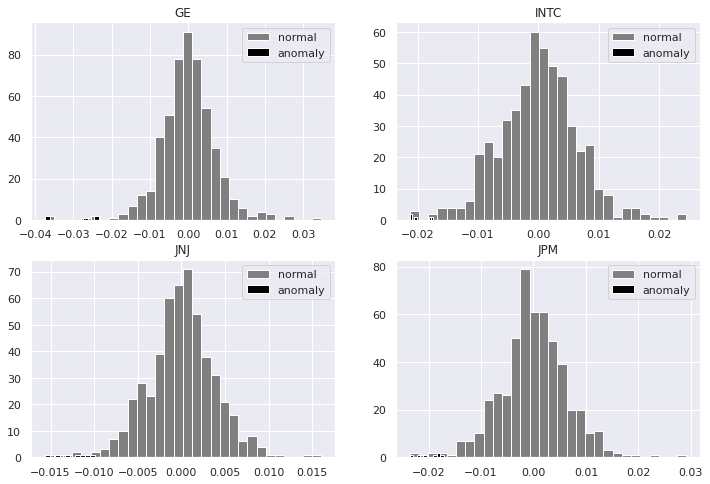

In [257]:
plt.figure(figsize=(12,8))
k=1

for i in stocks[8:12]:
  plt.subplot(2,2,k)
  crash_data_sliced['residuals'][crash_data_sliced.TICKER==i].hist(label='normal', bins=30, color='gray')
  outliers=crash_data_sliced['residuals'][(crash_data_sliced.TICKER==i)&(crash_data_sliced.neg_outliers>0)]
  outliers.hist(color='black', label='anomaly')
  plt.title(i)
  plt.legend()
  k+=1
plt.show()

In [258]:
crash_data_sliced=crash_data_sliced.set_index('date')
crash_data_sliced.index=pd.to_datetime(crash_data_sliced.index)

In [259]:
std=crash_data.groupby('TICKER')['RET'].resample('W').std()\
.reset_index()
crash_dataw['std']=pd.DataFrame(std['RET'])

In [260]:
yearly_data = crash_data_sliced.groupby('TICKER')['residuals']\
                .resample('Y').agg(['mean', 'std'])\
                .reset_index()
yearly_data.columns=['TICKER', 'date', 'mean', 'std']
yearly_data.head()


,TICKER,date,mean,std
0,AAPL,2010-12-31,0.000686,0.008291
1,AAPL,2011-12-31,0.000431,0.009088
2,AAPL,2012-12-31,-0.000079,0.008056
3,AAPL,2013-12-31,-0.001019,0.009096
4,AAPL,2014-12-31,0.000468,0.006174


In [261]:
merge_crash=pd.merge(crash_data_sliced.reset_index(), yearly_data, how='outer', on=['TICKER','date'])


In [262]:
merge_crash[['annual_mean', 'annual_std']]=merge_crash\
.sort_values(by=['TICKER','date'])\
.iloc[:,-2:]\
.fillna(method='bfill')
merge_crash['residuals']=merge_crash.sort_values(by=['TICKER', 'date'])\
['residuals']\
.fillna(method='ffill')
merge_crash=merge_crash.drop(merge_crash.iloc[:,-4:-2],axis=1)

In [263]:
crash_risk_out=[]
for j in stocks:
  for k in range(len(merge_crash[merge_crash.TICKER==j])):
    if merge_crash[merge_crash.TICKER==j]['residuals'].iloc[k]<\
    merge_crash[merge_crash.TICKER==j]['annual_mean'].iloc[k]-\
    3.09*\
    merge_crash[merge_crash.TICKER==j]['annual_std'].iloc[k]:
      crash_risk_out.append(1)
    else:
      crash_risk_out.append(0)


In [264]:
merge_crash['crash_risk']=crash_risk_out
merge_crash['crash_risk'].value_counts()

0    13476
1       44
Name: crash_risk, dtype: int64

In [265]:
merge_crash=merge_crash.set_index('date')
merge_crash_annual=merge_crash.groupby('TICKER')\
.resample('1Y')['crash_risk'].sum().reset_index()

In [266]:
down=[]
for j in range(len(merge_crash)):
  if merge_crash['residuals'].iloc[j]<\
  merge_crash['annual_mean'].iloc[j]:
    down.append(1)
  else:
    down.append(0)

In [267]:
merge_crash=merge_crash.reset_index()
merge_crash['down']=pd.DataFrame(down)
merge_crash['up']=1-merge_crash['down']
down_residuals=merge_crash[merge_crash.down==1]\
[['residuals','TICKER', 'date']]
up_residuals=merge_crash[merge_crash.up==1]\
[['residuals', 'TICKER', 'date']]

In [268]:
down_residuals['residuals_down_sq']=down_residuals['residuals']**2
down_residuals['residuals_down_cubic']=down_residuals['residuals']**3
up_residuals['residuals_up_sq']=up_residuals['residuals']**2
up_residuals['residuals_up_cubic']=up_residuals['residuals']**3
down_residuals['down_residuals']=down_residuals['residuals']
up_residuals['up_residuals']=up_residuals['residuals']
del down_residuals['residuals']
del up_residuals['residuals']
                   

In [269]:
merge_crash['residuals_sq']=merge_crash['residuals']**2
merge_crash['residuals_cubic']=merge_crash['residuals']**3

In [270]:
merge_crash_all=merge_crash.merge(down_residuals, on=['TICKER', 'date'],
                                  how='outer')
merge_crash_all=merge_crash_all.merge(up_residuals,
                                      on=['TICKER', 'date'],
                                      how='outer')

In [271]:
cols=['BIDLO', 'ASKHI', 'residuals',
      'annual_std', 'residuals_sq', 'residuals_cubic',
      'down','up', 'residuals_up_sq', 'residuals_down_sq',
      'neg_outliers']
merge_crash_all=merge_crash_all.set_index('date')
merge_grouped=merge_crash_all.groupby('TICKER')[cols]\
.resample('1Y').sum().reset_index()
merge_grouped['neg_outliers']=np.where(merge_grouped.neg_outliers>=1,1,0)

In [272]:
merge_grouped=merge_grouped.set_index('date')
merge_all=merge_grouped.groupby('TICKER')\
.resample('1Y').agg({'down':['sum', 'count'],
                     'up':['sum','count']})\
                     .reset_index()
merge_all.head()

TICKER       date down        up      
                     sum count sum count
0   AAPL 2010-12-31   27     1  23     1
1   AAPL 2011-12-31   26     1  27     1
2   AAPL 2012-12-31   28     1  26     1
3   AAPL 2013-12-31   24     1  29     1
4   AAPL 2014-12-31   22     1  31     1

In [273]:
merge_grouped['down']=merge_all['down']['sum'].values
merge_grouped['up']=merge_all['up']['sum'].values
merge_grouped['count']=merge_grouped['down']+merge_grouped['up']


In [274]:
merge_grouped=merge_grouped.reset_index()

In [275]:
merge_grouped['duvol']=np.log(((merge_grouped['up']-1)*
                               merge_grouped['residuals_down_sq'])/
                              ((merge_grouped['down']-1)*
                               merge_grouped['residuals_up_sq']))

In [276]:
merge_grouped['duvol'].mean()

-0.02337149875811484

In [277]:
merge_grouped['ncskew']=-(((merge_grouped['count']*
                            (merge_grouped['count']-1)**
                            (3/2))*
                           merge_grouped['residuals_cubic'])/
                          (((merge_grouped['count']-1)*
                            (merge_grouped['count']-2))*
                           merge_grouped['residuals_sq']**
                           (3/2)))

In [278]:
merge_grouped['ncskew'].mean()

-0.031025284134663003

In [279]:
merge_grouped['crash_risk']=merge_crash_annual['crash_risk']
merge_grouped['crash_risk']=np.where(merge_grouped.crash_risk>=1,1,0)

In [280]:
merge_crash_all_grouped2=merge_crash_all.groupby('TICKER')\
[['VOL', 'PRC']]\
.resample('1Y').mean().reset_index()
merge_grouped[['VOL','PRC']]=merge_crash_all_grouped2[['VOL','PRC']]
merge_grouped[['ncskew', 'duvol']].corr()

,ncskew,duvol
ncskew,1.000000,0.909937
duvol,0.909937,1.000000


In [281]:
bs=pd.read_csv('bs_v.3.csv')
bs['Date']=pd.to_datetime(bs.datadate, format='%Y%m%d')
bs['annual_date']=bs['Date'].dt.year

In [282]:
bs['ROA']=bs['ni']/bs['at']
bs['leverage']=bs['lt']/bs['at']

In [283]:
merge_grouped['annual_date']=merge_grouped['date'].dt.year
bs['TICKER']=bs.tic
del bs['tic']


In [284]:
merge_ret_bs=pd.merge(bs, merge_grouped,
                      on=['TICKER', 'annual_date'])


In [285]:
merge_ret_bs2=merge_ret_bs.set_index('Date')
merge_ret_bs2=merge_ret_bs2.groupby('TICKER').resample('Y').mean()
merge_ret_bs2.reset_index(inplace=True)

In [286]:
merge_ret_bs2['vol_csho_diff']=(merge_ret_bs2.groupby('TICKER')\
                                ['VOL'].shift(-1)/
                                merge_ret_bs2.groupby('TICKER')\
                                ['csho'].shift(-1))
merge_ret_bs2['dturn1']=merge_ret_bs2['VOL']/merge_ret_bs2['csho']
merge_ret_bs2['dturn']=merge_ret_bs2['vol_csho_diff']-\
merge_ret_bs2['dturn1']


In [287]:
merge_ret_bs2['p/e']=merge_ret_bs2['PRC']/merge_ret_bs2['ni']
merge_ret_bs2['turnover_rate']=merge_ret_bs2['VOL']/\
merge_ret_bs2['csho']
merge_ret_bs2['equity_share']=merge_ret_bs2['ceq']/\
(merge_ret_bs2['ceq']+merge_ret_bs2['dt'])
merge_ret_bs2['firm_size']=np.log(merge_ret_bs2['at'])



In [288]:
merge_ret_bs2['cefd']=(((merge_ret_bs2['at']-
                         merge_ret_bs2['lt'])/merge_ret_bs2['csho'])-
                       merge_ret_bs2['PRC'])/(merge_ret_bs2['at']-
                                              merge_ret_bs2['lt'])/merge_ret_bs2['csho']
                                              

In [289]:
merge_ret_bs2=merge_ret_bs2.set_index('Date')
merge_ret_bs2['buying_volume']=merge_ret_bs2['VOL']*\
(merge_ret_bs2['PRC']-
 merge_ret_bs2['BIDLO'])/\
 (merge_ret_bs2['ASKHI']-
 merge_ret_bs2['BIDLO'])
merge_ret_bs2['selling_volume']=merge_ret_bs2['VOL']*\
(merge_ret_bs2['ASKHI']-
 merge_ret_bs2['PRC'])/\
 (merge_ret_bs2['ASKHI']-
  merge_ret_bs2['BIDLO'])
buying_volume=merge_ret_bs2.groupby('TICKER')['buying_volume']\
.resample('Y').sum().reset_index()
selling_volume=merge_ret_bs2.groupby('TICKER')['selling_volume']\
.resample('Y').sum().reset_index()
del buying_volume['TICKER']
del buying_volume['Date']

In [290]:
buy_sel_vol=pd.concat([buying_volume,selling_volume], axis=1)
buy_sel_vol['bsi']=(buy_sel_vol.buying_volume-
                    buy_sel_vol.selling_volume)/\
                    (buy_sel_vol.buying_volume+
                     buy_sel_vol.selling_volume)

In [291]:
merge_ret_bs2=merge_ret_bs2.reset_index()
merge_ret_bs2=pd.merge(buy_sel_vol, merge_ret_bs2, on=['TICKER','Date'])

In [292]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [293]:
firm_sentiment=merge_ret_bs2[['p/e', 'turnover_rate',
                              'equity_share', 'cefd',
                              'leverage', 'bsi']]
firm_sentiment=firm_sentiment.apply(lambda x: x.fillna(x.mean()),
                                    axis=0)
                              

In [294]:
firm_sentiment_std=StandardScaler().fit_transform(firm_sentiment)
pca=PCA(n_components=6)
pca_market_sentiment=pca.fit_transform(firm_sentiment_std)
print('Explained Variance Ratios per Component are:\n {}'\
      .format(pca.explained_variance_ratio_))


Explained Variance Ratios per Component are:
 [0.35828322 0.2752777  0.15343653 0.12206041 0.06681776 0.02412438]


In [295]:
loadings_1=pd.DataFrame(pca.components_.T*
                        np.sqrt(pca.explained_variance_),
                        columns=['PC1', 'PC2', 'PC3',
                                 'PC4', 'PC5', 'PC6'],
                        index=firm_sentiment.columns)
loadings_1

,PC1,PC2,PC3,PC4,PC5,PC6
p/e,-0.250786,0.326182,0.911665,0.056323,0.000583,0.021730
turnover_rate,-0.101554,0.854432,-0.197381,0.201749,0.428911,-0.008421
equity_share,-0.913620,-0.162406,-0.133783,0.224513,-0.031672,0.271443
cefd,0.639570,-0.118671,0.038422,0.754467,-0.100176,0.014146
leverage,0.917298,0.098311,0.068633,-0.264369,0.089224,0.265335
bsi,0.006731,0.878526,-0.173740,-0.044127,-0.446735,0.022520


In [296]:
df_loading1=pd.DataFrame(loadings_1.mean(axis=1))
df_loading1

,0
p/e,0.177616
turnover_rate,0.196289
equity_share,-0.124254
cefd,0.204626
leverage,0.195739
bsi,0.040529


In [297]:
firm_sentiment=pd.DataFrame(np.dot(pca_market_sentiment,
                                   np.array(df_loading1)))
merge_ret_bs2['firm_sent']=firm_sentiment

In [298]:
merge_ret_bs2['log_size']=np.log(merge_ret_bs2['at'])


In [299]:
merge_ret_bs2.set_index(['TICKER','Date'], inplace=True)

In [300]:
X=(merge_ret_bs2[['log_size', 'rect', 'ppegt', 'dturn',
                  'ncskew', 'residuals', 'ROA', 'annual_std',
                  'firm_sent']]).shift(1)
X['neg_outliers']=merge_ret_bs2['neg_outliers']

In [302]:
!pip install git+https://github.com/nhennetier/pyeconometrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/nhennetier/pyeconometrics to /tmp/pip-req-build-al3a78km
  Running command git clone --filter=blob:none --quiet https://github.com/nhennetier/pyeconometrics /tmp/pip-req-build-al3a78km
  Resolved https://github.com/nhennetier/pyeconometrics to commit 30fef862554be3d472a753e638e33a0d13540312
  Preparing metadata (setup.py) ... done
  Created wheel for pyeconometrics: filename=pyeconometrics-1.0.2-py3-none-any.whl size=10133 sha256=3d1ace180bf5657b74be37677f3601be057e360ed70236c02a6d9b0d1b23fb65
  Stored in directory: /tmp/pip-ephem-wheel-cache-bgyz0q21/wheels/ad/0f/c5/23a06c119ad4de652fcb0976bdb18fac4e58400b913b2a33eb
Successfully built pyeconometrics


In [304]:
from pyeconometrics.panel_discrete_models import FixedEffectPanelModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [306]:
FE_ML=FixedEffectPanelModel()
FE_ML.fit(X, 'neg_outliers')
FE_ML.summary()

Dep. Variable:                      neg_outliers   Pseudo R-squ.:        0.09219
Model:                 Panel Fixed Effects Logit   Log-Likelihood:       -83.395
Method:                                      MLE   LL-Null:              -91.864
No. Observations:                            193   LLR p-value:            0.076
Df Model:                                      9                                
Converged:                                  True                                
                              coef  std err        t    P>|t| [95.0% Conf. Int.]
--------------------------------------------------------------------------------
_cons                     -2.0232    1.100   -1.839    0.033    -4.180     0.133
log_size                   0.1521    0.089    1.700    0.045    -0.023     0.327
rect                      -0.0000    0.000   -4.111    0.000    -0.000    -0.000
ppegt                     -0.0000    0.000   -0.576    0.282    -0.000     0.000
dturn                      0

In [307]:
del X['neg_outliers']
X['crash_risk']=merge_ret_bs2['crash_risk']

In [308]:
FE_crash=FixedEffectPanelModel()
FE_crash.fit(X,'crash_risk')
FE_crash.summary()

Dep. Variable:                        crash_risk   Pseudo R-squ.:        0.04944
Model:                 Panel Fixed Effects Logit   Log-Likelihood:       -55.863
Method:                                      MLE   LL-Null:              -58.769
No. Observations:                            193   LLR p-value:            0.831
Df Model:                                      9                                
Converged:                                  True                                
                              coef  std err        t    P>|t| [95.0% Conf. Int.]
--------------------------------------------------------------------------------
_cons                     -2.7130    1.151   -2.358    0.009    -4.969    -0.457
log_size                   0.1697    0.094    1.804    0.036    -0.015     0.354
rect                      -0.0000    0.000   -1.604    0.054    -0.000     0.000
ppegt                     -0.0000    0.000   -0.519    0.302    -0.000     0.000
dturn                      0